<img src="https://crecmemes.files.wordpress.com/2014/06/seriouslyprophet.jpg?w=584" width = 300 height = 200 />

In [614]:
import time 
script_start = time.time()
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from meteostat import Point, Daily, Stations
import glob
import plotly.express as px
import plotly.offline as py_offline
import plotly.graph_objs as go
import seaborn as sns
import scipy as sp
from holidays import Lithuania

import itertools
import matplotlib.ticker as ticker
import json
from fbprophet.utilities import regressor_coefficients
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot, plot_cross_validation_metric, plot_plotly, plot_components_plotly
from fbprophet.diagnostics import cross_validation, performance_metrics
from prophet.serialize import model_to_json, model_from_json

import calendar
import altair as alt
import click
from tqdm import notebook
from math import sqrt
import datetime
from pandas.tseries import offsets
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

from pylab import rcParams
rcParams['figure.figsize'] = (24, 8)
plt.style.use('seaborn')

import numexpr
numexpr.set_num_threads(12)
numexpr.set_num_threads(12)

12

# Functions

In [615]:
%run lt_kmi_features.ipynb # function is stored in another notebook

# MAPE score function
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
# SMAPE score function
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)
# Model validation
def scoring(x, y, z):
    x = x.fillna(0)
    print (z, ":", {'MAE' : f"{round(mean_absolute_error(x, y), 0):,}"
                   ,'RSME' : f"{round(np.sqrt(mean_squared_error(x, y)), 0):,}"
                   ,'MAPE' :  f"{mean_absolute_percentage_error(x, y)/100:.1%}"
                   ,'SMAPE' :  f"{smape(x, y)/100:.1%}"
                    })

# Data input

In [616]:
df = pd.read_csv(os.path.join(os.path.abspath(''), 'data\daily_sales_data.csv'), sep = ';')

target = 'y'
df['ds'] = pd.to_datetime(df['ds'])

print('First date:', df['ds'].dt.date.min())
print('Last date:', df['ds'].dt.date.max(), '\n')

df.info(memory_usage = 'deep')
df.tail(5)

First date: 2017-01-02
Last date: 2022-08-18 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2033 entries, 0 to 2032
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      2033 non-null   datetime64[ns]
 1   y       2033 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 31.9 KB


ds              y
2028 2022-08-14  894494.058623
2029 2022-08-15  770490.537488
2030 2022-08-16  902236.372441
2031 2022-08-17  928993.149658
2032 2022-08-18  890028.425844

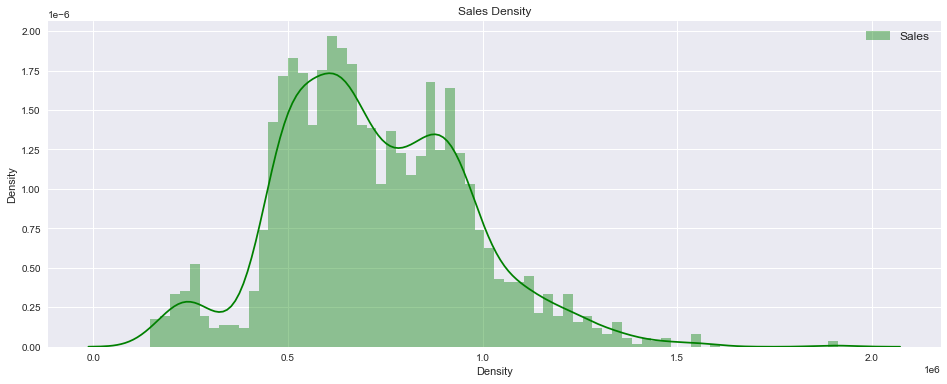

In [617]:
plt.subplots(figsize = (16, 6))
sns.distplot(df['y'].dropna(), kde = True, label = 'Sales', color = 'green', bins = 70)
plt.legend(prop = {'size': 12})
plt.title('Sales Density')
plt.xlabel('Density')
plt.show()

In [618]:
fig = go.Figure()
fig.update_layout(width = 1200, height = 500, title = 'Daily Sales Time-Series', legend = dict(orientation = "h", yanchor = "bottom", y = 1, xanchor = "right", x = 1))
fig.add_trace(go.Scatter(x = df['ds'], y = df['y'], name = 'Sales',))
fig.show()

## Feature engineering

### Time Based Features

In [619]:
def future_dates(df):
    '''
    Creates empty dates until end of the year
    '''
    current_max_date = df['ds'].max() + datetime.timedelta(days = 1)
    year_end_date = df['ds'].max() + pd.tseries.offsets.YearEnd()
    future_dates = pd.date_range(current_max_date, year_end_date).tolist()
    future_dates = pd.DataFrame(future_dates, columns = ['ds'])
    return future_dates
    
df = pd.concat([df, future_dates(df)], axis = 0)

print('New date range:', df['ds'].min().date(), '-', df['ds'].max().date())

New date range: 2017-01-02 - 2022-12-31


In [620]:
%%time
df['month'] = df['ds'].dt.month
df['year'] = df['ds'].dt.year
df['weekofyear'] = [int(x.strftime("%U")) for x in df['ds']]
df['dayofweek'] = [i.weekday() + 1 for i in df['ds']]
df['quarter'] = [int(np.ceil(x / 3))  for x in df['ds'].dt.month]
df['dayofmonth'] = [x for x in df['ds'].dt.day]
df['is_leap_year'] = [1 if calendar.isleap(x) else 0 for x in df['ds'].dt.year]
df['season'] = df['ds'].dt.month % 12 // 3 + 1
df['weekend'] = [1 if x in (6, 7) else 0 for x in df['dayofweek']]
df['month_and_dayofmonth'] = [x.strftime("%m %d") for x in df['ds']]

date_lst = df[(df['dayofweek'] == 6) & (df['month_and_dayofmonth'] < '12 24')].sort_values('ds', ascending = False).\
                        groupby(['year'])['ds'].nlargest(10).reset_index()[['ds']]

date_lst['pre_xmas_saturdays'] = 1

df = pd.merge(df, date_lst, how = 'left', on = ['ds'])
df['pre_xmas_saturdays'] = np.where(df['pre_xmas_saturdays'] == 1, 1, 0)
df.tail(5)

Wall time: 41.9 ms


ds   y  month  year  weekofyear  dayofweek  quarter  dayofmonth  \
2163 2022-12-27 NaN     12  2022          52          2        4          27   
2164 2022-12-28 NaN     12  2022          52          3        4          28   
2165 2022-12-29 NaN     12  2022          52          4        4          29   
2166 2022-12-30 NaN     12  2022          52          5        4          30   
2167 2022-12-31 NaN     12  2022          52          6        4          31   

      is_leap_year  season  weekend month_and_dayofmonth  pre_xmas_saturdays  
2163             0       1        0                12 27                   0  
2164             0       1        0                12 28                   0  
2165             0       1        0                12 29                   0  
2166             0       1        0                12 30                   0  
2167             0       1        1                12 31                   0

### COVID influence 

In [621]:
def covid_lockdown_feature(date):
    date = datetime.datetime(*date.timetuple()[:-4])
    if (datetime.datetime.strptime('2020-03-16', "%Y-%m-%d") <= date <= datetime.datetime.strptime('2020-04-15', "%Y-%m-%d")):
        return 100
    elif (datetime.datetime.strptime('2020-12-16', "%Y-%m-%d") <= date <= datetime.datetime.strptime('2021-03-14', "%Y-%m-%d")):
        return 100
    elif (datetime.datetime.strptime('2021-09-13', "%Y-%m-%d") <= date <= datetime.datetime.strptime('2022-01-16', "%Y-%m-%d")):
        return 25
    elif (datetime.datetime.strptime('2022-01-17', "%Y-%m-%d") <= date <= datetime.datetime.strptime('2022-02-04', "%Y-%m-%d")):
        return 25
    elif (datetime.datetime.strptime('2022-02-05', "%Y-%m-%d") <= date <= datetime.datetime.strptime('2022-03-04', "%Y-%m-%d")):
        return 25
    else: 
        return 0
    
df['covid_lockdown'] = np.vectorize(covid_lockdown_feature)(df['ds'].map(datetime.datetime.date))
df['pre_covid_lockdown'] = [1 if x.strftime('%Y-%m-%d') in ['2020-03-15', '2021-09-12'] else 0 for x in df['ds']]

In [622]:
def covid_lockdown_weekday(date, dayofweek, day):
    date = datetime.datetime(*date.timetuple()[:-4])
    if (datetime.datetime.strptime('2020-03-16', "%Y-%m-%d") <= date <= datetime.datetime.strptime('2020-04-15', "%Y-%m-%d")) and (dayofweek == day):
        return 100
    elif (datetime.datetime.strptime('2020-12-16', "%Y-%m-%d") <= date <= datetime.datetime.strptime('2021-03-14', "%Y-%m-%d")) and (dayofweek == day):
        return 100
    elif (datetime.datetime.strptime('2021-09-13', "%Y-%m-%d") <= date <= datetime.datetime.strptime('2022-01-16', "%Y-%m-%d")) and (dayofweek == day):
        return 0
    elif (datetime.datetime.strptime('2022-01-17', "%Y-%m-%d") <= date) and (dayofweek == day):
        return 0
    else: 
        return 0   
    
df['monday+covid'] = np.vectorize(covid_lockdown_weekday)(date = df['ds'].map(datetime.datetime.date), dayofweek = df['dayofweek'], day = 1)
df['tuesday+covid'] = np.vectorize(covid_lockdown_weekday)(date = df['ds'].map(datetime.datetime.date), dayofweek = df['dayofweek'], day = 2)
df['wednesday+covid'] = np.vectorize(covid_lockdown_weekday)(date = df['ds'].map(datetime.datetime.date), dayofweek = df['dayofweek'], day = 3)
df['thursday+covid'] = np.vectorize(covid_lockdown_weekday)(date = df['ds'].map(datetime.datetime.date), dayofweek = df['dayofweek'], day = 4)
df['friday+covid'] = np.vectorize(covid_lockdown_weekday)(date = df['ds'].map(datetime.datetime.date), dayofweek = df['dayofweek'], day = 5)
df['saturday+covid'] = np.vectorize(covid_lockdown_weekday)(date = df['ds'].map(datetime.datetime.date), dayofweek = df['dayofweek'], day = 6)
df['sunday+covid'] = np.vectorize(covid_lockdown_weekday)(date = df['ds'].map(datetime.datetime.date), dayofweek = df['dayofweek'], day = 7)

### Weather API

In [623]:
# Get nearby weather stations
def get_station(Latitude, Longitude):
    station = Stations()
    station = station.nearby(Latitude, Longitude) 
    return station.fetch(1)


stations = []
stations.append(get_station(Latitude = 54.8985207, Longitude = 23.9035965)) ## Kaunas
stations.append(get_station(Latitude = 54.687157, Longitude = 25.279652)) ## Vilnius
stations.append(get_station(Latitude = 55.703297, Longitude = 21.144279)) ## Klaipėda
# stations.append(get_station(Latitude = 55.93333, Longitude = 23.31667)) ## Šiauliai
# stations.append(get_station(Latitude = 55.73333 , Longitude = 24.35)) ## Panevėžys

stations_names = {0:'Kaunas', 1:'Vilnius', 2:'Klaipėda', 3:'Šiauliai', 4:'Panevėžys'}
                
weather = []
for key, station in enumerate(stations):
    w = Daily(station, df['ds'].min(), df['ds'].max())
    w = w.normalize().interpolate().fetch()[['tavg']]
    w['station'] = stations_names[key]
    weather.append(w)

weather = pd.concat(weather, axis = 0)
weather = weather.reset_index().pivot(index='time', columns='station', values=['tavg'])

weather.columns = ['_'.join(col).strip() for col in weather.columns.values]

In [624]:
print('Min ds:', weather.index.min().date(), '-', 'Max ds:', weather.index.max().date())

if weather.index.min() == df['ds'].min() + datetime.timedelta(days = 1) - pd.tseries.offsets.YearBegin():
    pass
else:
    current_min_date = weather.index.min() - datetime.timedelta(days = 1)
    beginning_dates = pd.date_range(df['ds'].min(), current_min_date).tolist()
    beginning_dates = pd.DataFrame(beginning_dates, columns = ['time']).set_index('time')
    weather = pd.concat([weather, beginning_dates], axis = 0).sort_index()
    print('Min ds:', weather.index.min().date(), '-', 'Max ds:', weather.index.max().date())
    
fig = go.Figure()
fig.update_layout(width = 1200, height = 500, title = 'Avg. temprature in main cities', legend = dict(orientation = "h", yanchor = "bottom", y = 1, xanchor = "right", x = 1))
for city in weather[[col for col in weather if col.startswith('tavg')]].columns.to_list():
    fig.add_trace(go.Scatter(x=weather.index, y=weather[city], mode='lines', name=city))
fig.show()

Min ds: 2017-01-02 - Max ds: 2022-12-31
Min ds: 2017-01-02 - Max ds: 2022-12-31


In [625]:
# Mean tempature over year
weather['year'] = weather.reset_index()['time'].dt.year.values
weather.groupby(['year'])[[col for col in weather if col.startswith('tavg')]].mean().T.round(3)

year            2017   2018   2019   2020   2021    2022
tavg_Kaunas    7.718  8.393  8.994  9.285  7.584   9.842
tavg_Klaipėda  8.477  8.912  9.684  9.996  8.460  10.130
tavg_Vilnius   7.244  7.922  8.613  8.698  6.933   9.311

In [626]:
# check for null values
weather.set_index('year')[[col for col in weather if col.startswith('tavg')]].isna().sum(level = 0).T

year           2017  2018  2019  2020  2021  2022
tavg_Kaunas       0     0     0     0     0   120
tavg_Klaipėda     0     0     0     0     0   120
tavg_Vilnius      0     0     0     0     0   120

In [627]:
weather = weather[[col for col in weather if col.startswith('tavg')]].reset_index().rename({'time' :'ds'}, axis = 'columns')

In [628]:
weather['dayofyear'] = weather['ds'].dt.dayofyear
weather['year'] = weather.reset_index()['ds'].dt.year.values

years = [datetime.date.today().year-1, datetime.date.today().year-2, datetime.date.today().year-3]

for i in weather[[col for col in weather if col.startswith('tavg')]].columns.to_list():
    means = weather[weather['ds'].dt.year.isin(years)].groupby('dayofyear')[i].agg('mean')
    # Solution:
    weather[i] = np.where(weather[i].isnull(),weather['dayofyear'].map(means), weather[i])
    weather[i] = weather[i].fillna(0)
    
    
fig = go.Figure()
fig.update_layout(width = 1000, height = 500, title = 'Avg. temprature in main cities', legend = dict(orientation = "h", yanchor = "bottom", y = 1, xanchor = "right", x = 1))
for city in weather[[col for col in weather if col.startswith('tavg')]].columns.to_list():
    fig.add_trace(go.Scatter(x=weather.index, y=weather[city], mode='lines', name=city))
fig.show()

In [629]:
df = df.set_index('ds').join(weather.set_index('ds')[[col for col in weather if col.startswith('tavg')]], how = 'left').reset_index()

### Key Macroeconomic Indicators
https://www.lb.lt/lt/naujausios-ekonomikos-prognozes#ex-1-1 <br>
https://osp.stat.gov.lt/en/pagrindiniai-salies-rodikliai

Run from lt_kmi_features.ipynb file

In [630]:
df['export_growth'] = np.vectorize(export_func)(df['year'])
df['import_growth'] = np.vectorize(import_func)(df['year'])    
df['unemployed_growth'] = np.vectorize(unemployed_func)(df['year'])
df['employed_growth'] = np.vectorize(employed_func)(df['year'])   
df['private_consump_expend'] = np.vectorize(privat_consump_func)(df['year'])   
df['governm_consump_expend'] = np.vectorize(govern_consump_func)(df['year'])   
df['salary_growth'] = np.vectorize(salary_func)(df['year'])

In [631]:
df.groupby(['year'])[['salary_growth', 'export_growth', 'import_growth', 'unemployed_growth', 'employed_growth', 'private_consump_expend', 'governm_consump_expend']]\
    .mean().style.format("{:,.1f}").background_gradient(axis = 0, cmap = 'copper_r')

In [632]:
df = df.merge(gdp_data, on = ['year', 'quarter'], how = 'left')

## https://tradingeconomics.com/lithuania/forecast
## GDP Annual Growth Rate (%)

df['gdp_growth'] = np.where((df['gdp_growth'].isnull()) & (df['year'] == 2022) & (df['quarter'] == 2), 4.6,( 
                     np.where((df['gdp_growth'].isnull()) & (df['year'] == 2022) & (df['quarter'] == 3), 0.5,( 
                     np.where((df['gdp_growth'].isnull()) & (df['year'] == 2022) & (df['quarter'] == 4), 0.1,( 
                     np.where((df['gdp_growth'].isnull()) & (df['year'] == 2023) & (df['quarter'] == 1), 0.7,( 
                     np.where((df['gdp_growth'].isnull()) & (df['year'] == 2023) & (df['quarter'] == 2), 3.0,( 
                     np.where((df['gdp_growth'].isnull()) & (df['year'] == 2023), 3.9,
                                                                                      df['gdp_growth'])))))))))))

inf_data = df.groupby(['year', 'quarter'])['gdp_growth'].mean().reset_index()
inf_data['index'] = inf_data['year'].astype(str) + '-' + inf_data['quarter'].astype(str) 

fig = px.bar(inf_data, x = 'index', y = 'gdp_growth', text_auto = True)
fig.layout = dict(xaxis=dict(type="category"),yaxis=dict(tickformat=".1f"))
fig.update_layout(title = 'GDP Annual Growth Rate (%)', height = 600, width = 1400)
fig.show()

In [633]:
df = df.merge(cpi_data, on = ['year', 'month', 'quarter'], how = 'left')

## https://tradingeconomics.com/lithuania/forecast
## Inflation Rate (%)
df['inflation_growth'] = np.where((df['inflation_growth'].isnull()) & (df['year'] == 2022) & (df['quarter'] == 2), 21.0,( 
                         np.where((df['inflation_growth'].isnull()) & (df['year'] == 2022) & (df['quarter'] == 3), 18.5,( 
                         np.where((df['inflation_growth'].isnull()) & (df['year'] == 2022) & (df['quarter'] == 4), 15.4,( 
                         np.where((df['inflation_growth'].isnull()) & (df['year'] == 2023) & (df['quarter'] == 1), 12.4,( 
                         np.where((df['inflation_growth'].isnull()) & (df['year'] == 2023) & (df['quarter'] == 2), 9.0,( 
                         np.where((df['inflation_growth'].isnull()) & (df['year'] == 2023), 4.1,
                                                                                                 df['inflation_growth'])))))))))))

inf_data = df.groupby(['year', 'month'])['inflation_growth'].mean().reset_index()
inf_data['index'] = inf_data['year'].astype(str) + '-' + inf_data['month'].astype(str) 

fig = px.bar(inf_data, x = 'index', y = 'inflation_growth', text_auto = True)
fig.layout = dict(xaxis=dict(type="category"), yaxis=dict(tickformat=".1f"))
fig.update_layout(title = 'Inflation rate (%)', height = 600, width = 1400, uniformtext_minsize = 12)
fig.update_traces(textfont_size = 12, textangle = 0, textposition = "outside", cliponaxis=False)
fig.show()

## EDA

In [634]:
px.box(df, x = "year", y = "y"
    , points = "all" # can also be outliers, or suspectedoutliers, or False
    , color = "year", hover_data = ["ds"]
    , title = 'Outlier inspection', width = 1000, height = 500
      ).show()

In [635]:
fig = go.Figure()
fig.update_layout(width = 1200, height = 500,title = 'Sales during COVID-19', legend = dict(orientation = "h", yanchor = "bottom", y = 1, xanchor = "right", x = 1))
fig.add_trace(go.Scatter(x = df['ds'], y = df['y'], name = 'Sales',))
fig.add_trace(go.Scatter(x = df[(df['covid_lockdown'] > 0)]['ds'], y = df[(df['covid_lockdown'] > 0)]['y'], name = 'covid_lockdown', mode = 'markers'))
fig.show()

In [636]:
## Investigating sales without covid and outliers
plot_df = df[(df['y'].notnull()) & (df['covid_lockdown'] == 0) & (df['pre_covid_lockdown'] == 0)]

# removing outliers from dataframe
plot_df_out = plot_df[~plot_df['ds'].isin(['2020-12-14'
                                          ,'2020-12-15'
                                          ,'2022-01-01'
                                          ,'2021-04-05'
                                          ])]

fig = px.box(plot_df_out, x = "year", y = "y"
             , points = "all" # can also be outliers, or suspectedoutliers, or False
             , color = "year", hover_data = ["ds"], title = 'Outlier inspection', width = 1000, height = 500)
fig.show()

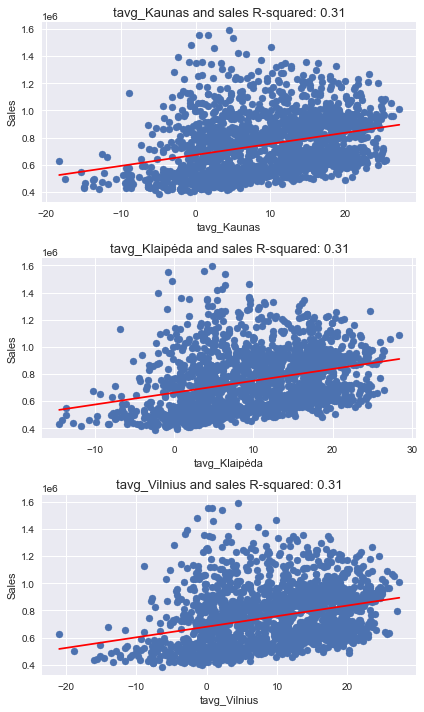

In [637]:
def correl_plot(df, feature_list, figsize_x = 19, figsize_y = 10):

    c = 1  # initialize plot counter
    fig = plt.figure(figsize = (figsize_x, figsize_y))
    
    for item in feature_list:
        if len(feature_list) % 2 == 0:
            plt.subplot(2, int(len(feature_list) / 2), c)
        elif len(feature_list) % 2 == 1:
            plt.subplot(3, int((len(feature_list)) / 2), c)
        else:
            plt.subplot(1, len(feature_list), c)
        sales = df['y']
        feature = df[item]

        r_squared = sp.stats.linregress(sales, feature)[2]
        plt.scatter(feature, sales)
        plt.xlabel(item, fontsize = 11)
        plt.ylabel('Sales', fontsize = 11)
        plt.plot(np.unique(feature), np.poly1d(np.polyfit(feature, sales, 1))(np.unique(feature)), color = 'r')
        plt.title(f'{item} and sales R-squared: %0.2f' % r_squared, fontsize = 13)
        plt.tight_layout()
        c += 1

    plt.show()
    
correl_plot(df = plot_df_out,
            feature_list = [col for col in weather if col.startswith('tavg')],
            figsize_x = 6, figsize_y = 10)

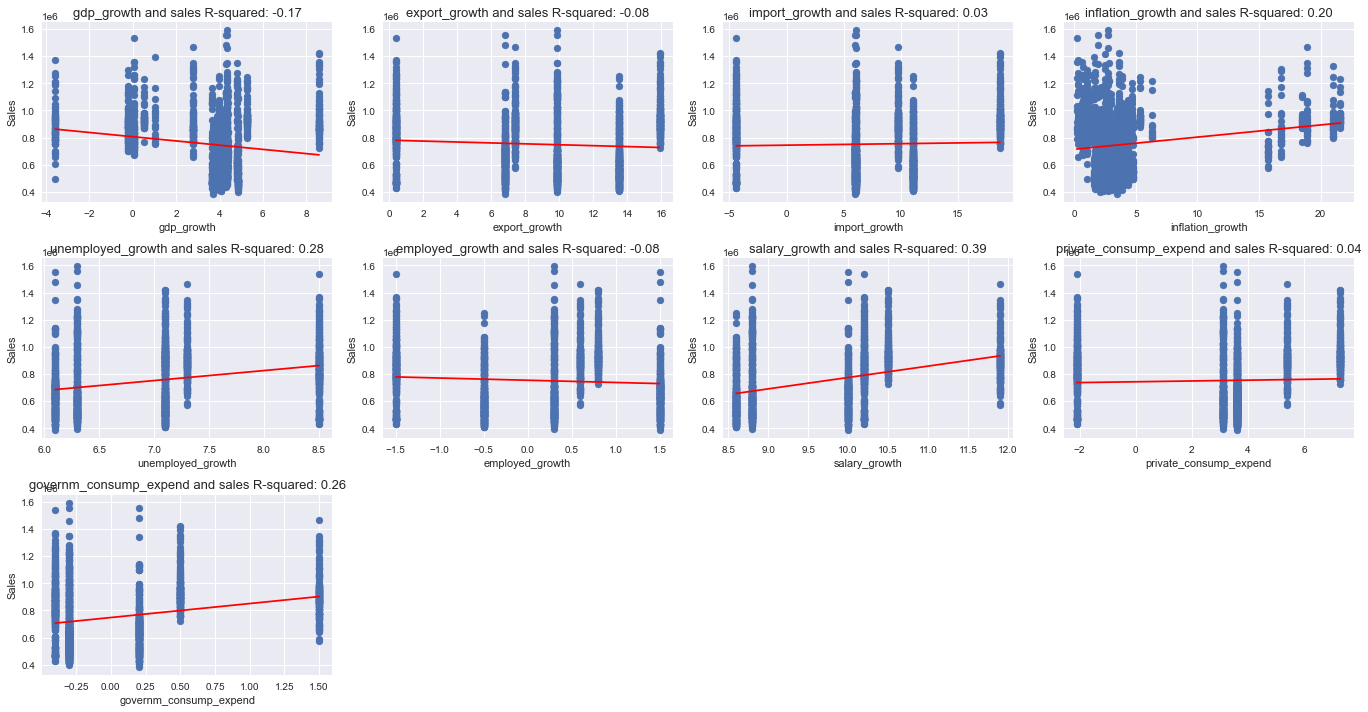

In [638]:
correl_plot(df = plot_df_out
            , feature_list = ['gdp_growth', 'export_growth','import_growth'
                              , 'inflation_growth', 'unemployed_growth'
                              , 'employed_growth', 'salary_growth',
                              'private_consump_expend', 'governm_consump_expend'
                             ])

## Adjusted feature engineering

In [639]:
## VDA 
def vda_wednesday_feature(date, dayofweek, covid_lockdown):
    date = datetime.datetime(*date.timetuple()[:-4])
    if (datetime.datetime.strptime('2016-11-05', "%Y-%m-%d") <= date < datetime.datetime.strptime('2017-01-01', "%Y-%m-%d")) and (dayofweek == 3) and (covid_lockdown == 0):
        return 100
    elif (datetime.datetime.strptime('2017-02-22', "%Y-%m-%d") <= date < datetime.datetime.strptime('2018-01-01', "%Y-%m-%d")) and (dayofweek == 3) and (covid_lockdown == 0):
        return 100
    elif (datetime.datetime.strptime('2018-10-10', "%Y-%m-%d") <= date < datetime.datetime.strptime('2018-12-22', "%Y-%m-%d")) and (dayofweek == 3) and (covid_lockdown == 0):
        return 100
    elif (datetime.datetime.strptime('2019-02-20', "%Y-%m-%d") <= date < datetime.datetime.strptime('2020-03-15', "%Y-%m-%d")) and (dayofweek == 3) and (covid_lockdown == 0):
        return 100
    elif (datetime.datetime.strptime('2021-10-09', "%Y-%m-%d") <= date < datetime.datetime.strptime('2021-11-29', "%Y-%m-%d")) and (dayofweek == 3) and (covid_lockdown == 0):
        return 50
    else: 
        return 0 
    
df['vda_wednesday'] = np.vectorize(vda_wednesday_feature)(df['ds'].map(datetime.datetime.date), df['dayofweek'], df['covid_lockdown'])

def vda_saturday_feature(date, dayofweek, covid_lockdown):
    date = datetime.datetime(*date.timetuple()[:-4])
    if (datetime.datetime.strptime('2018-09-15', "%Y-%m-%d") <= date < datetime.datetime.strptime('2020-03-15', "%Y-%m-%d")) and (dayofweek == 6) and (covid_lockdown == 0):
        return 100
    elif (datetime.datetime.strptime('2020-03-15', "%Y-%m-%d") <= date < datetime.datetime.strptime('2021-06-20', "%Y-%m-%d")) and (dayofweek == 6) and (covid_lockdown == 0):
        return 100
    elif (datetime.datetime.strptime('2021-10-09', "%Y-%m-%d") <= date < datetime.datetime.strptime('2021-11-19', "%Y-%m-%d")) and (dayofweek == 6) and (covid_lockdown == 0):
        return 100
    else: 
        return 0   
    
df['vda_saturday'] = np.vectorize(vda_saturday_feature)(df['ds'].map(datetime.datetime.date), df['dayofweek'], df['covid_lockdown'])

In [640]:
fig = go.Figure()
fig.update_layout(width = 1400, height = 600, title = 'Sales during VDA', legend = dict(orientation = "h", yanchor = "bottom", y = 1, xanchor = "right", x = 1))
fig.add_trace(go.Scatter(x = df['ds'], y = df['y'], name = 'Target',))
fig.add_trace(go.Scatter(x = df[(df['vda_wednesday'] > 0)]['ds'], y = df[(df['vda_wednesday'] > 0)]['y'], name = 'vda_wednesday', mode = 'markers'))
fig.add_trace(go.Scatter(x = df[(df['vda_saturday'] > 0)]['ds'], y = df[(df['vda_saturday'] > 0)]['y'], name = 'vda_saturday', mode = 'markers'))
fig.show()

In [641]:
fig = px.box(df[(df['year'] == 2019)], x = "season", y = "y", points = "outliers", color = "dayofweek", hover_data = ["ds"]
             , title = 'Day of week: Inspection', category_orders = {'dayofweek': np.sort(df['dayofweek'].unique())}, width = 1200, height = 500)
fig.show()

# Preparing data for model

## Training data

In [642]:
df['cap'] = round(df[df.year.isin([datetime.date.today().year, datetime.date.today().year - 1, datetime.date.today().year + 1])]['y'].max() * 1.15, -4)
df['floor'] = 100.0

In [643]:
df.columns

Index(['ds', 'y', 'month', 'year', 'weekofyear', 'dayofweek', 'quarter',
       'dayofmonth', 'is_leap_year', 'season', 'weekend',
       'month_and_dayofmonth', 'pre_xmas_saturdays', 'covid_lockdown',
       'pre_covid_lockdown', 'monday+covid', 'tuesday+covid',
       'wednesday+covid', 'thursday+covid', 'friday+covid', 'saturday+covid',
       'sunday+covid', 'tavg_Kaunas', 'tavg_Klaipėda', 'tavg_Vilnius',
       'export_growth', 'import_growth', 'unemployed_growth',
       'employed_growth', 'private_consump_expend', 'governm_consump_expend',
       'salary_growth', 'gdp_growth', 'inflation_growth', 'vda_wednesday',
       'vda_saturday', 'cap', 'floor'],
      dtype='object')

In [644]:
class CustomException(Exception):
    pass

def train_data(method, df):
    if int(method) == 1:
        date = input('Custom date: ')
        return df[(df[target].notnull()) & (df['ds'] <= date)], 1, 0  # Custom training data
    elif int(method) == 2:
        return df[(df[target].notnull())], 0, 0 # Whole data
    elif int(method) == 3:
        idx = int(input('Test size: '))
        return df[(df[target].notnull())][:-idx], 1, idx  # Training data
    else:
        raise CustomException('Invalid input, no such method')

method = input(
"""Choose one input: 
  1. Training data by date (Enter custom date)
  2. Whole dataset
  3. Training data by size (Enter testing size by day count) \n
""")

data, scoring_flag, test_size = train_data(method, df)

exog_df = df.copy()
print('\nMax training data date:', data['ds'].dt.date.max())

time.sleep(2)

Choose one input: 
  1. Training data by date (Enter custom date)
  2. Whole dataset
  3. Training data by size (Enter testing size by day count) 

3
Test size: 60

Max training data date: 2022-06-19


## Removing Outliers

In [645]:
# removing outliers from dataframe
data = data[data['y'] > 100]

data.loc[(data['ds'].isin(['2020-12-14'
                          ,'2020-03-15'
                          ,'2020-12-15'
                          ,'2022-01-01'
                          ,'2021-04-05'
                          ]))
         , 'y'] = None

## Adding custom holidays

In [646]:
def creating_holidays_df():
    # adding additional new holidays
    velynes_antra_diena = pd.DataFrame({'holiday': 'VėlinėsAntraDiena',
                                        'ds': pd.to_datetime(['2020-11-02', '2021-11-02', '2022-11-02', '2023-11-02']), 
                                        'lower_window': 0,
                                        'upper_window': 1
                                        })
    
    pries_mindaugo_diena = pd.DataFrame({'holiday': 'PriešMindaugoDieną',
                                         'ds': pd.to_datetime(['2017-07-05', '2018-07-05', '2019-07-05', '2020-07-05', '2021-07-05', '2022-07-05', '2023-07-05']), 
                                         'lower_window': 0,
                                         'upper_window': 1
                                        })
    
    pries_darbo_diena = pd.DataFrame({'holiday': 'PriešDarboDieną',
                                         'ds': pd.to_datetime([str(datetime.datetime.strptime('2018-05-01', "%Y-%m-%d") -  datetime.timedelta(days = 1))[:10],
                                                               str(datetime.datetime.strptime('2019-05-01', "%Y-%m-%d") -  datetime.timedelta(days = 1))[:10],
                                                               str(datetime.datetime.strptime('2020-05-01', "%Y-%m-%d") -  datetime.timedelta(days = 1))[:10],
                                                               str(datetime.datetime.strptime('2021-05-01', "%Y-%m-%d") -  datetime.timedelta(days = 1))[:10],
                                                               str(datetime.datetime.strptime('2022-05-01', "%Y-%m-%d") -  datetime.timedelta(days = 1))[:10],
                                                               str(datetime.datetime.strptime('2023-05-01', "%Y-%m-%d") -  datetime.timedelta(days = 1))[:10]
                                                              ]), 
                                         'lower_window': 0,
                                         'upper_window': 1
                                        })
    
    pries_kucias = pd.DataFrame({'holiday': 'PriešKūčias',
                                         'ds': pd.to_datetime([str(datetime.datetime.strptime('2018-12-24', "%Y-%m-%d") -  datetime.timedelta(days = 1))[:10],
                                                               str(datetime.datetime.strptime('2019-12-24', "%Y-%m-%d") -  datetime.timedelta(days = 1))[:10],
                                                               str(datetime.datetime.strptime('2020-12-24', "%Y-%m-%d") -  datetime.timedelta(days = 1))[:10],
                                                               str(datetime.datetime.strptime('2021-12-24', "%Y-%m-%d") -  datetime.timedelta(days = 1))[:10],
                                                               str(datetime.datetime.strptime('2022-12-24', "%Y-%m-%d") -  datetime.timedelta(days = 1))[:10],
                                                               str(datetime.datetime.strptime('2023-12-24', "%Y-%m-%d") -  datetime.timedelta(days = 1))[:10],
                                                               
                                                               str(datetime.datetime.strptime('2018-12-24', "%Y-%m-%d") -  datetime.timedelta(days = 2))[:10],
                                                               str(datetime.datetime.strptime('2019-12-24', "%Y-%m-%d") -  datetime.timedelta(days = 2))[:10],
                                                               str(datetime.datetime.strptime('2020-12-24', "%Y-%m-%d") -  datetime.timedelta(days = 2))[:10],
                                                               str(datetime.datetime.strptime('2021-12-24', "%Y-%m-%d") -  datetime.timedelta(days = 2))[:10],
                                                               str(datetime.datetime.strptime('2022-12-24', "%Y-%m-%d") -  datetime.timedelta(days = 2))[:10],
                                                               str(datetime.datetime.strptime('2023-12-24', "%Y-%m-%d") -  datetime.timedelta(days = 2))[:10]
                                                              ]), 
                                         'lower_window': 0,
                                         'upper_window': 1
                                        })
    holidays = pd.concat((velynes_antra_diena, pries_mindaugo_diena, pries_darbo_diena, pries_kucias))
    return holidays

holidays = creating_holidays_df()

# Tuning model parameters
<p style="font-size:15px">
<li> Choose <b>'Y'</b> to hyper tune parameters </li> 
<li> Choose <b>'N'</b> to use previous model's parameters </li>
</p>

<img src="https://images.ctfassets.net/pqts2v0qq7kz/ICaoSlEPjHVI59MIBQHhO/8ce4bf3fff919a07aa00c4c0d2c9f101/14.png" width = 500 height = 200 />

* <b> Training data (initial) </b>: The amount of data set aside for training. The parameter is in the API called initial. <br>
* <b> Horizon </b>: The data set aside for validation. If you don’t define a period the model will be fitted with Horizon/2. <br>
* <b> Cutoff (period) </b>: a forecast is made for every observed point between cutoff and cutoff + horizon.

In [647]:
%%time
def prophet_hypertune():
    '''
    Hyper tuning parameters and choosing best combination according to RMSE score.
    '''
    global best_params
    param_grid = {  
                    'uncertainty_samples' : [0]
                    ,'changepoint_prior_scale': [0.15, 0.25, 0.30]
                    ,'seasonality_prior_scale': [0.05, 0.10, 0.20]
                    ,'holidays_prior_scale' : [0.05, 0.10, 0.20]
                    ,'yearly_seasonality' : [True] 
                    ,'weekly_seasonality' : [True]
                    ,'daily_seasonality' : [False]
                    ,'changepoint_range' : [0.95]
                    ,'growth' : ['linear']
                    ,'seasonality_mode' : ['additive']
                 }

    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    rmse = []  # Store the RMSE for each params here

    # Use cross validation to evaluate all parameters
    for params in notebook.tqdm(all_params):
        model = Prophet(**params, holidays = holidays)
        model.add_country_holidays(country_name = 'LT')
    ## Weekends before Christmas
        model.add_regressor('pre_xmas_saturdays')      
    ##---------------------------------------------------------------------------------
    # VDA
        model.add_regressor('vda_wednesday')           # VDA
        model.add_regressor('vda_saturday')            # VDA
    ##---------------------------------------------------------------------------------
    ## COVID related features
        model.add_regressor('covid_lockdown')           
        model.add_regressor('monday+covid')             
        model.add_regressor('tuesday+covid')           
        model.add_regressor('wednesday+covid')          
        model.add_regressor('thursday+covid')          
        model.add_regressor('friday+covid')             
        model.add_regressor('saturday+covid')           
        model.add_regressor('sunday+covid')             
    ##---------------------------------------------------------------------------------
    ## Macroeconomic features
        model.add_regressor('gdp_growth')                   
        model.add_regressor('inflation_growth')             
        model.add_regressor('export_growth')                
        model.add_regressor('import_growth')                
        model.add_regressor('unemployed_growth')            
        model.add_regressor('employed_growth')              
        model.add_regressor('salary_growth')               
        model.add_regressor('private_consump_expend')       
        model.add_regressor('governm_consump_expend')      
    #---------------------------------------------------------------------------------
    ## Weather temp. data for three regions
    ## 2022.08.23 praktiškai nėra korialecijos (~ .30), neduoda naudos"
    #     model.add_regressor('tavg_Kaunas')      
    #     model.add_regressor('tavg_Klaipėda')   
    #     model.add_regressor('tavg_Vilnius')     
    #     model.add_regressor('tavg_Šiauliai')     
    #     model.add_regressor('tavg_Panevėžys')         
        model.fit(data) 

        period_days = 30
        forecast_cnt = 5
        horizon_days = period_days / 2
        initial_days = round(((data['ds'].max() - (datetime.timedelta(days = period_days) * forecast_cnt)) - data['ds'].min()).days, -1)
    
        df_cv = cross_validation(model, 
                                 horizon = f'{horizon_days} days',
                                 period = f'{period_days} days',
                                 initial = f'{initial_days} days',
                                 parallel = 'processes')
        
        df_p = performance_metrics(df_cv, rolling_window = 1)
        rmse.append(df_p['rmse'].values[0])

    # Find the best parameters
    tuning_results = pd.DataFrame(all_params)
    tuning_results['rmse'] = rmse
    best_params = all_params[np.argmin(rmse)]   

    
if click.confirm('Hyper-tune model parameters?', default = True):     
    prophet_hypertune()
    with open('best_params.json', 'w') as fp:
        json.dump(best_params, fp)   # Save best model parameters
else: 
    with open('best_params.json', 'r') as fp:
        best_params = json.load(fp)  # Load previous model's best parameters

Hyper-tune model parameters? [Y/n]: n
Wall time: 1.39 s


<img src="https://c.tenor.com/qdd-yN4sS6EAAAAd/blinds-venetian.gif" width = 300 height = 200 />

In [648]:
best_params

{'uncertainty_samples': 0,
 'changepoint_prior_scale': 0.3,
 'seasonality_prior_scale': 0.2,
 'holidays_prior_scale': 0.2,
 'yearly_seasonality': True,
 'weekly_seasonality': True,
 'daily_seasonality': False,
 'changepoint_range': 0.95,
 'growth': 'linear',
 'seasonality_mode': 'additive'}

In [649]:
# best_params["yearly_seasonality"] = True
# best_params["weekly_seasonality"] = True
# best_params["daily_seasonality"] = False
# best_params["changepoint_prior_scale"] = 0.25
# best_params["seasonality_prior_scale"] = 0.10
# best_params["holidays_prior_scale"] = 0.10
# best_params["changepoint_range"] = 0.95
# best_params['growth'] = 'linear'                      # flat | linear | logistic
# best_params['seasonality_mode'] = 'additive'          # multiplicative | additive
best_params['uncertainty_samples'] = 100
best_params

{'uncertainty_samples': 100,
 'changepoint_prior_scale': 0.3,
 'seasonality_prior_scale': 0.2,
 'holidays_prior_scale': 0.2,
 'yearly_seasonality': True,
 'weekly_seasonality': True,
 'daily_seasonality': False,
 'changepoint_range': 0.95,
 'growth': 'linear',
 'seasonality_mode': 'additive'}

In [650]:
# del best_params['mcmc_samples']

# Prophet model

## Fitting model

In [651]:
data.columns

Index(['ds', 'y', 'month', 'year', 'weekofyear', 'dayofweek', 'quarter',
       'dayofmonth', 'is_leap_year', 'season', 'weekend',
       'month_and_dayofmonth', 'pre_xmas_saturdays', 'covid_lockdown',
       'pre_covid_lockdown', 'monday+covid', 'tuesday+covid',
       'wednesday+covid', 'thursday+covid', 'friday+covid', 'saturday+covid',
       'sunday+covid', 'tavg_Kaunas', 'tavg_Klaipėda', 'tavg_Vilnius',
       'export_growth', 'import_growth', 'unemployed_growth',
       'employed_growth', 'private_consump_expend', 'governm_consump_expend',
       'salary_growth', 'gdp_growth', 'inflation_growth', 'vda_wednesday',
       'vda_saturday', 'cap', 'floor'],
      dtype='object')

In [652]:
%%time
def prophet_model(data, exog_df):
    model = Prophet(**best_params,
                    holidays = holidays,
                    interval_width = 0.95
                   )
    model.add_country_holidays(country_name = 'LT')
    ## Weekends before Christmas
    model.add_regressor('pre_xmas_saturdays')      
    ##---------------------------------------------------------------------------------
    # VDA
    model.add_regressor('vda_wednesday')           # VDA
    model.add_regressor('vda_saturday')            # VDA
    ##---------------------------------------------------------------------------------
    ## COVID related features
    model.add_regressor('covid_lockdown')           
    model.add_regressor('monday+covid')             
    model.add_regressor('tuesday+covid')           
    model.add_regressor('wednesday+covid')          
    model.add_regressor('thursday+covid')          
    model.add_regressor('friday+covid')             
    model.add_regressor('saturday+covid')           
    model.add_regressor('sunday+covid')             
    ##---------------------------------------------------------------------------------
    ## Macroeconomic features
    model.add_regressor('gdp_growth')                   
    model.add_regressor('inflation_growth')             
    model.add_regressor('export_growth')                
    model.add_regressor('import_growth')                
    model.add_regressor('unemployed_growth')            
    model.add_regressor('employed_growth')              
    model.add_regressor('salary_growth')               
    model.add_regressor('private_consump_expend')       
    model.add_regressor('governm_consump_expend')      
    #---------------------------------------------------------------------------------
    ## Weather temp. data for three regions
    ## 2022.08.23 praktiškai nėra korialecijos (~ .30), neduoda naudos"
    #     model.add_regressor('tavg_Kaunas')      
    #     model.add_regressor('tavg_Klaipėda')   
    #     model.add_regressor('tavg_Vilnius')     
    #     model.add_regressor('tavg_Šiauliai')     
    #     model.add_regressor('tavg_Panevėžys')         
    model.fit(data) 

    future = exog_df[['ds'
                      ## Weekends before Christmas
                      ,'pre_xmas_saturdays'              
                      ## VDA 
                      ,'vda_wednesday'         
                      ,'vda_saturday'          
## ---------------------------------------------------------------------------------
                      ## COVID related features
                      ,'covid_lockdown'          
                      ,'monday+covid'            
                      ,'tuesday+covid'          
                      ,'wednesday+covid'         
                      ,'thursday+covid'          
                      ,'friday+covid'            
                      ,'saturday+covid'          
                      ,'sunday+covid'            
##---------------------------------------------------------------------------------
                      ## Macroeconomic
                      ,'gdp_growth'              
                      ,'inflation_growth'         
                      ,'export_growth'            
                      ,'import_growth'           
                      ,'unemployed_growth'       
                      ,'employed_growth'         
                      ,'salary_growth'            
                      ,'private_consump_expend'            
                      ,'governm_consump_expend'            
#---------------------------------------------------------------------------------
                      ## Weather data
#                      ,'tavg_Kaunas'     
#                      ,'tavg_Klaipėda'  
#                      ,'tavg_Vilnius'   
#                      ,'tavg_Šiauliai'  
#                      ,'tavg_Panevėžys'    
##---------------------------------------------------------------------------------
                      ,'cap'                # Logistic growth cap
                      ,'floor'              # Logistic growth floor
                    ]]
    
    forecast = model.predict(future)
    
    with open('serialized_model.json', 'w') as fout:
        fout.write(model_to_json(model))  # Save model
        
    return forecast

forecast = prophet_model(data = data, exog_df = exog_df)

Wall time: 7.97 s


## Model diagnostics

In [653]:
with open('serialized_model.json', 'r') as fin:
    model = model_from_json(fin.read())  # Load model
    
plot_components_plotly(model, forecast, figsize = (1200, 200))

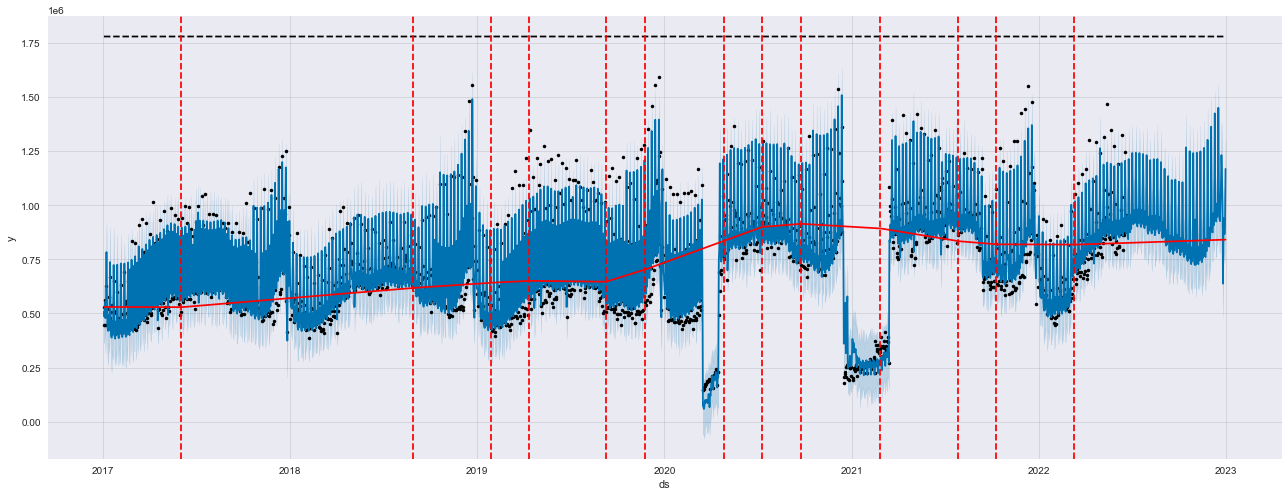

In [654]:
fig = model.plot(forecast, figsize = (18, 7))
add_changepoints_to_plot(fig.gca(), model, forecast);

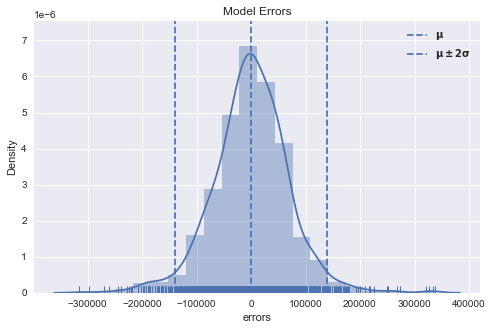

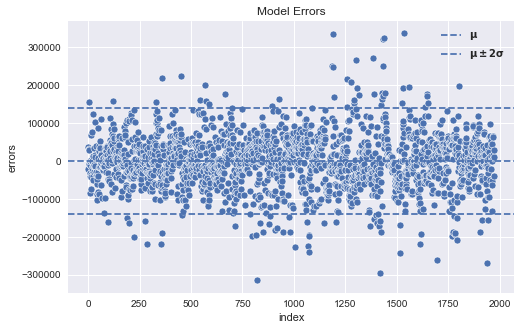

In [655]:
def error_plot():
    forecast.loc[:, 'errors'] = forecast.loc[:, 'yhat'] - data.loc[:, 'y']
    errors_mean = forecast['errors'].mean()
    errors_std = forecast['errors'].std()

    fig, ax = plt.subplots(figsize = (8, 5))
    sns.distplot(a=forecast['errors'], ax=ax, bins=20, rug=True)
    ax.axvline(x=errors_mean, linestyle='--', label=r'$\mu$')
    ax.axvline(x=errors_mean + 2*errors_std, linestyle='--', label=r'$\mu \pm 2\sigma$')
    ax.axvline(x=errors_mean - 2*errors_std, linestyle='--')
    ax.legend()
    ax.set(title='Model Errors');
    fig, ax = plt.subplots(figsize = (8, 5))

    sns.scatterplot(x='index', y='errors', data=forecast.reset_index(), ax=ax)
    ax.axhline(y=errors_mean, linestyle='--', label=r'$\mu$ ')
    ax.axhline(y=errors_mean + 2*errors_std, linestyle='--', label=r'$\mu \pm 2\sigma$')
    ax.axhline(y=errors_mean - 2*errors_std, linestyle='--')
    ax.legend()
    ax.set(title='Model Errors');

error_plot()

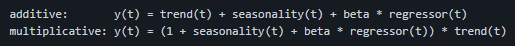
The estimated beta coefficient for each regressor roughly represents the increase in prediction value for a unit increase in the regressor value <br> 
(Note that the coefficients returned are always on the scale of the original data)

In [656]:
def reg_coefficients(regressor_coef):
    regressor_coef = regressor_coef[['regressor', 'regressor_mode', 'coef']].sort_values('coef')
    if best_params['seasonality_mode'] == 'additive':
        fstr = '{:,.2f}'
    else: 
        fstr = '{:,.3%}'
    return regressor_coef.style.format({'coef': f"{fstr}"}).apply(lambda x: ['color: %s' % '#ff6f69' if v < 0 else '' for v in x], subset = ['coef'], axis=0)

reg_coefficients(regressor_coefficients(model))

## Validating model

In [657]:
def validating_model(weeks = 4):
    # Creating test dataframes for plotting
    test_df = data[-(weeks * 7):][['ds', target]]
    fc_holidays = forecast[['ds', 'holidays']][(forecast['ds'].isin(test_df['ds']))]
    yhat = forecast[['ds', 'yhat']][(forecast['ds'].isin(test_df['ds']))]
    yhat_upper = forecast[['ds', 'yhat_upper']][(forecast['ds'].isin(test_df['ds']))]
    yhat_lower = forecast[['ds', 'yhat_lower']][(forecast['ds'].isin(test_df['ds']))]
          
    scoring(test_df.iloc[:,1], yhat.iloc[:,1], f'Data points tested: {test_df.shape[0]}')

    fig = go.Figure()
    fig.update_layout(width = 1200, height = 500, title = 'Prophet fitting ', legend = dict(orientation = "h", yanchor = "bottom", y = 1, xanchor = "right", x = 1))
    fig.add_trace(go.Scatter(x = test_df.iloc[:,0], y = test_df.iloc[:,1], name = 'Target',))
    fig.add_trace(go.Scatter(x = yhat.iloc[:,0], y = yhat.iloc[:,1], name = 'Forecast',))
    fig.add_trace(go.Scatter(x = yhat_upper.iloc[:,0], y = yhat_upper.iloc[:,1], name = 'yhat_upper', line_color = 'rgba(75, 119, 190, 0.2)'))
    fig.add_trace(go.Scatter(x = yhat_lower.iloc[:,0], y = yhat_lower.iloc[:,1], name = 'yhat_lower', fill = 'tonexty', line_color = 'rgba(75, 119, 190, 0.2)', fillcolor = 'rgba(75, 119, 190, 0.2)'))
    fig.add_trace(go.Scatter(x = fc_holidays.iloc[:,0], y = fc_holidays.iloc[:,1], name =  'Holidays',))
    fig.show()

forecast = forecast.set_index('ds').join(data.set_index('ds')['y'], how = 'left').reset_index().rename(columns = {'y':'fact'})    
validating_model(weeks = 8)

Data points tested: 56 : {'MAE': '47,784.0', 'RSME': '66,733.0', 'MAPE': '4.8%', 'SMAPE': '4.9%'}


In [658]:
print("OBB scoring:")
if scoring_flag == 1:
    scoring(df[df['y'].notnull()]['y'][-test_size:], forecast[forecast['ds'].isin(df[df['y'].notnull()]['ds'][-test_size:])]['yhat'], 'Test')

OBB scoring:
Test : {'MAE': '45,317.0', 'RSME': '64,321.0', 'MAPE': '4.7%', 'SMAPE': '4.6%'}


In [659]:
if scoring_flag == 1:
    score_test_data = df[df['y'].notnull()][-test_size:][['ds', 'y']]
    
fig = go.Figure()
fig.update_layout(width = 1400, height = 600, title = 'Daily sales forecasting', legend = dict(orientation = "h", yanchor = "bottom", y = 1, xanchor = "right", x = 1))
fig.add_trace(go.Scatter(x = data['ds'], y = data['y'], name = 'Target',))
fig.add_trace(go.Scatter(x = forecast['ds'], y = forecast['yhat'], name = 'Predicted',))
fig.add_trace(go.Scatter(x = forecast['ds'], y = forecast['holidays'], name = 'holidays',))
fig.add_trace(go.Scatter(x = forecast['ds'], y = forecast['covid_lockdown'], name = 'covid_lockdown',))

if 'score_test_data' in globals() and scoring_flag == 1:
    fig.add_trace(go.Scatter(x = score_test_data['ds'], y = score_test_data['y'], name = 'Test data',))

fig.show()

# Removing store non-working days

In [660]:
Easter_dates = []
for i in range(2016, 2025):
    mydict = Lithuania(years = i)
    Easter_dates.append(list(mydict.keys())[list(mydict.values()).index('Velykos')])

forecast = forecast[~forecast['ds'].dt.date.isin(Easter_dates)]                        # Easter
forecast = forecast[~((forecast['ds'].dt.month == 1) & (forecast['ds'].dt.day == 1))]   # New year
forecast = forecast[~((forecast['ds'].dt.month == 11) & (forecast['ds'].dt.day == 1))]  # Vespers
forecast = forecast[~((forecast['ds'].dt.month == 12) & (forecast['ds'].dt.day == 25))] # Christmas

forecast.loc[(forecast['yhat'] < 0), 'yhat'] = 0 # remove any negative forecasts.

# Forecast overview

In [661]:
print('Sales:')
for year in forecast.ds.dt.year.unique():
    print(f"{year} YTE results:", f"{round(df[(df['ds'] >= f'{year}-01-01') & (forecast['ds'] <= f'{year}-12-31') & (df['y'].notnull())]['y'].sum() + forecast[(forecast['ds'] >= f'{year}-01-01') & (forecast['ds'] <= f'{year}-12-31') & ~(forecast['ds'].isin(df[(df['ds'] >= f'{year}-01-01') & (forecast['ds'] <= f'{year}-12-31') & (df['y'].notnull())]['ds']))]['yhat'].sum(), 0):,}"[:-2], '€')


Sales:
2017 YTE results: 231,875,907 €
2018 YTE results: 239,101,582 €
2019 YTE results: 254,493,610 €
2020 YTE results: 276,466,403 €
2021 YTE results: 280,467,242 €
2022 YTE results: 308,456,718 €


In [662]:
forecast['month_'] = forecast['ds'].dt.month

pd.DataFrame(forecast[(forecast['ds'] >= '2022-01-01') & (forecast['ds'] <= '2022-12-31')].groupby([forecast['month_']])[['yhat']].sum())\
.style.format("{:,.0f}").background_gradient(axis = 0, cmap = 'copper_r')

In [663]:
forecast['week_'] = [int(x.strftime("%W")) + 1 for x in forecast['ds']]

pd.DataFrame(forecast[(forecast['ds'] > '2022-01-01') & (forecast['ds'] < '2022-12-31')].\
        groupby([forecast['week_']])[['yhat']].sum()).\
        style.format("{:,.0f}").background_gradient(axis = 0, cmap = 'copper_r')